In [15]:
import yfinance as yf
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd

#### **EXTRACTING DATA**

In [16]:
#LQ45 stocks tickers that has IPO before january 2020  
tickers = ["ACES.JK", "ADRO.JK", "AKRA.JK",
           "AMRT.JK", "ANTM.JK", "ARTO.JK", "ASII.JK", "BBCA.JK",
           "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK",
           "BRPT.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK",
           "ICBP.JK", "INCO.JK", "INDF.JK", "INKP.JK",
           "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK",
           "MAPI.JK", "MDKA.JK", "MEDC.JK",
           "PGAS.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK",
           "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"]
#Importing data using yfinance
start = "2019-12-31"
end = "2025-01-01"
data0  = yf.download(tickers, start=start, end=end)
#Pick Adjusted Close data
close0 = data0["Close"]
#close0 = close0.dropna()
#Pick monthly Close Adjusted Close data
monthly_close0 = close0.resample('ME').last()

[*********************100%***********************]  38 of 38 completed


In [17]:
#Calculate returns and miuhat for rach stocks 
returns0 = []
miuhat0 = []
for ticker in tickers:
    prices = monthly_close0[ticker].values
    sim_ret = ((prices[1:] / prices[:-1]) - 1) * 100 #Simple returns
    returns0.append(sim_ret) #Miuhat
    miuhat0.append(np.mean(sim_ret))

#### **CORRELATION MATRIX**

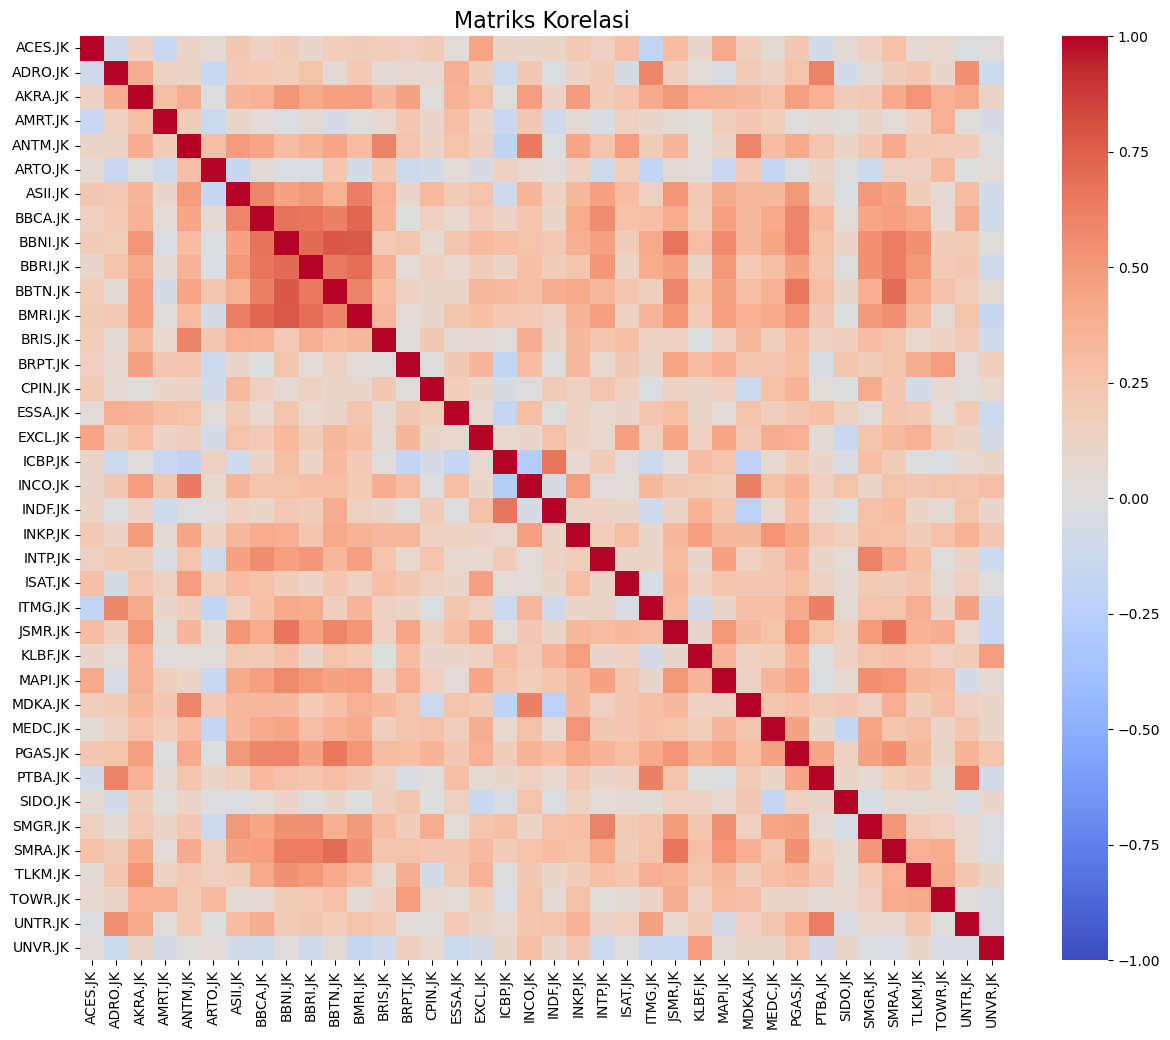

In [18]:
#Correlation matrix visualization
import seaborn as sns
df_returns = pd.DataFrame(np.array(returns0).T, columns=tickers)
corr_matrix = df_returns.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            square=True)
plt.title("Matriks Korelasi", fontsize=16)
plt.show()

#### **CORRELATION FILTERING**

In [19]:
def compute_cvar(returns, beta):
    """Function that calculate CVaR of returns given beta"""
    losses = -returns
    N = len(losses)

    model = pyo.ConcreteModel()
    # Variables
    model.eta = pyo.Var()
    model.z = pyo.Var(range(N), domain=pyo.NonNegativeReals) 
    # Objective function
    model.obj = pyo.Objective(
        expr=model.eta + (1 / ((1 - beta) * N)) * sum(model.z[i] for i in range(N)),
        sense=pyo.minimize
    )
    # Constraints
    model.constraints = pyo.ConstraintList()
    for i in range(N):
        model.constraints.add(model.z[i] >= losses[i] - model.eta)
        model.constraints.add(model.z[i] >= 0)
    # Solve with GLPK
    solver = pyo.SolverFactory("glpk")
    result = solver.solve(model, tee=False)
    eta_val = pyo.value(model.eta)
    cvar_val = eta_val + (1 / ((1 - beta) * N)) * sum(pyo.value(model.z[i]) for i in range(N))
    return cvar_val

In [20]:
def compute_csr(returns, beta):
    """Function that calculate Conditional Sharpe Ratio (CSR) with a given beta"""
    miuhat = np.mean(returns)
    cvar_val = compute_cvar(returns, beta)
    if cvar_val != 0:
        csr_val = miuhat / cvar_val
    else:
        csr_val = np.nan  # avoid division by zero
    return csr_val

In [21]:
def correlation_filter(returns_list, tickers, beta, threshold):
    """Filter asset using Correlation Filtering and compare they're CSR"""
    csr_values = []
    for j in range(len(tickers)):
        csr_val = compute_csr(returns_list[j], beta)
        csr_values.append(csr_val)
    returns_array = np.array(returns_list)
    corr_matrix = np.corrcoef(returns_array)
    filtered_assets = tickers.copy()
    n = len(tickers)
    for i in range(1, n):
        for j in range(i):
            if abs(corr_matrix[i, j]) > threshold:
                if csr_values[i] >= csr_values[j]:
                    if tickers[j] in filtered_assets:
                        filtered_assets.remove(tickers[j])
                else:
                    if tickers[i] in filtered_assets:
                        filtered_assets.remove(tickers[i])
    
    return filtered_assets

In [22]:
#Pick the hyperparameter
beta = 0.95
threshold = 0.2
#What are the stocks that will be optimize the proportion
stock_list = correlation_filter(returns0, tickers, beta, threshold)
print(stock_list)

['ADRO.JK', 'AMRT.JK', 'ARTO.JK']


#### **MEAN-CVAR MODEL**

In [23]:
def mean_cvar(ticker_list, beta, start, end, n_points):
    """Using Mean-CVaR to Find the Optimal Weight in a Portofolio"""
    #Importing data
    data = yf.download(ticker_list, start=start, end=end, progress=False)
    #close = data["Close"]
    close = data["Close"].dropna()
    #Using monthly data
    monthly_close = close.resample('ME').last()
    #Calculating returns and miuhat
    returns = []
    miuhat = []
    for ticker in ticker_list:
        prices = monthly_close[ticker].values
        sim_ret = ((prices[1:] / prices[:-1]) - 1) * 100
        returns.append(sim_ret)
        miuhat.append(np.mean(sim_ret))
    returns = np.array(returns)
    miuhat = np.array(miuhat)
    #Defining all the target returns that is gonna be used
    n_assets, n_periods = returns.shape
    Rtar_list = np.linspace(min(miuhat), max(miuhat), n_points)
    #Saving all the CVaR, portofolio return, and Weight
    CVaR_list = []
    Rp_list = []
    weight_list = []
    # Step 3 — Loop through all target returns
    for Rtar in Rtar_list:
        model = pyo.ConcreteModel()
        #Variables
        model.w = pyo.Var(range(n_assets), domain=pyo.NonNegativeReals)
        model.eta = pyo.Var()
        model.z = pyo.Var(range(n_periods), domain=pyo.NonNegativeReals)
        # Objective function
        model.obj = pyo.Objective(
            expr=model.eta + (1 / ((1 - beta) * n_periods)) * sum(model.z[t] for t in range(n_periods)),
            sense=pyo.minimize
        )
        # Constraints
        model.cons = pyo.ConstraintList()
        model.cons.add(sum(model.w[i] for i in range(n_assets)) == 1)
        model.cons.add(sum(model.w[i] * miuhat[i] for i in range(n_assets)) >= Rtar)
        for t in range(n_periods):
            model.cons.add(model.z[t] >= -sum(model.w[i] * returns[i, t] for i in range(n_assets)) - model.eta)
        #Using GLPK Solver
        solver = pyo.SolverFactory("glpk")
        result = solver.solve(model, tee=False)

        if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal:
            current_weights = [pyo.value(model.w[i]) for i in range(n_assets)]
            
            actual_Rp = sum(current_weights[i] * miuhat[i] for i in range(n_assets))
            
            CVaR_list.append(pyo.value(model.obj))
            Rp_list.append(actual_Rp)
            weight_list.append(current_weights)
    return [CVaR_list, Rp_list, weight_list, Rtar_list]

In [24]:
#How much portofolio that is calculated
n_points = 10
#Finding all the best portofolio
cvar_list, Rp_list, weight_list, Rtar_list = mean_cvar(stock_list, beta, start, end, n_points)
print(f"How many portofolio that has been optimize: {len(Rp_list)}")
print(f"How many unique portofolio returns: {len(set(Rp_list))}")

How many portofolio that has been optimize: 10
How many unique portofolio returns: 8


#### **EFFICIENT FRONTIER GRAPH**

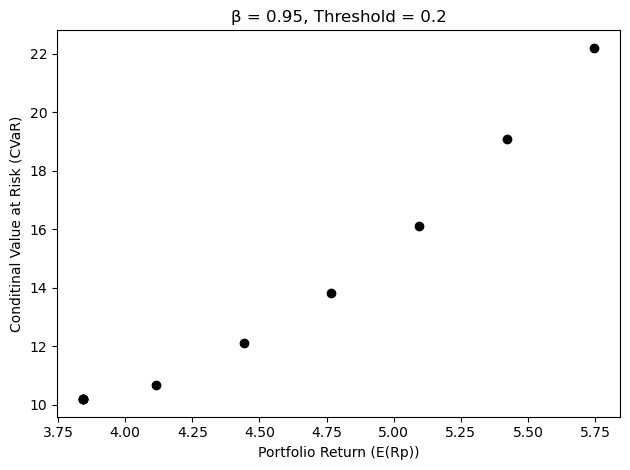

In [25]:
fig, ax = plt.subplots()
ax.scatter(Rp_list, cvar_list, color='black', alpha=1)
ax.set_title(f"β = {beta}, Threshold = {threshold}")
ax.set_xlabel("Portfolio Return (E(Rp))")
ax.set_ylabel("Conditinal Value at Risk (CVaR)")

plt.tight_layout()
plt.show()

#### **IMPORT TO EXCEL**

In [26]:
# === Flatten data structures ===
Rp = Rp_list
CVaR = cvar_list
weights = weight_list
Rtar = Rtar_list
# === Safety checks ===
n_portfolios = len(Rp)
if not (len(CVaR) == n_portfolios == len(weights)):
    raise ValueError(f"Length mismatch: Rp({len(Rp)}), CVaR({len(CVaR)}), Weights({len(weights)})")
# === Build DataFrame ===
df = pd.DataFrame(weights, columns=stock_list)
df.insert(0, 'CVaR', CVaR)
df.insert(0, 'Rp', Rp)
df.insert(0,'Rtar',Rtar)
# === Round and export ===
df = df.round(9)
output_filename = f"mean_cvar_portfolio_results.xlsx"
df.to_excel(output_filename, index=False)
display(df)

,Rtar,Rp,CVaR,ADRO.JK,AMRT.JK,ARTO.JK
0,2.807788,3.841387,10.198283,0.384054,0.374832,0.241114
1,3.134405,3.841387,10.198283,0.384054,0.374832,0.241114
2,3.461022,3.841387,10.198283,0.384054,0.374832,0.241114
3,3.787639,3.841387,10.198283,0.384054,0.374832,0.241114
4,4.114256,4.114256,10.688892,0.394921,0.274265,0.330814
5,4.440873,4.440873,12.130998,0.265555,0.255298,0.479147
6,4.767490,4.767490,13.811011,0.282925,0.131814,0.585261
7,5.094107,5.094107,16.099372,0.202779,0.077789,0.719432
8,5.420724,5.420724,19.074426,0.010908,0.103341,0.885750
9,5.747341,5.747341,22.194402,0.000000,0.000000,1.000000


#### **FINDING THE HIGHEST CONDITIONAL SHARPE RATIO (CSR)**

In [27]:
#Calculating the CSR for all portofolio
csr_list = []
for i in range(len(Rp_list)):
    csr_list.append(Rp_list[i]/cvar_list[i])
#Finding the highest CSR
max_val = max(csr_list)
#What is the index of the highest CSR in the list
max_index = csr_list.index(max_val)
#What is the portofolio return of the highest CSR
CSRmax_Rp = [Rp_list[max_index]]
#What is the CVaR of the highest CSR
CSRmax_cvar = [cvar_list[max_index]]
print(csr_list)
print("The highest CSR is :",max_val,"With Index :",max_index)

[0.37666994025561323, 0.37666994025561323, 0.37666994025561346, 0.37666994025561373, 0.3849094501099114, 0.3660764486551866, 0.34519483554156627, 0.3164164749549548, 0.2841880264620164, 0.25895450892582395]
The highest CSR is : 0.3849094501099114 With Index : 4


#### **GRAPH**

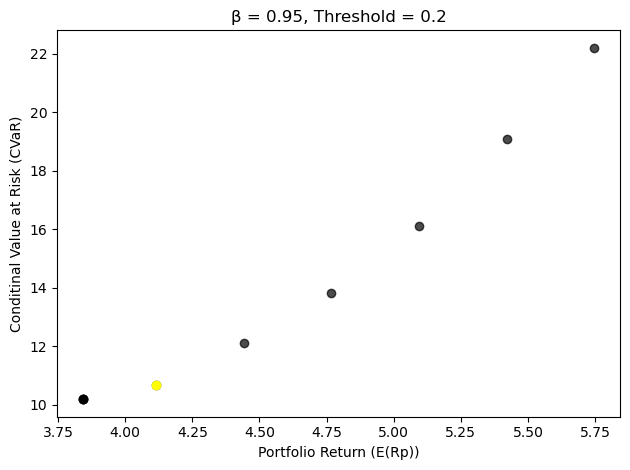

In [28]:
#From all the portofolio, which portofolio has the higher CSR
fig, ax = plt.subplots()
ax.scatter(Rp_list, cvar_list, color='black', alpha=0.7)
ax.scatter(CSRmax_Rp, CSRmax_cvar, color='yellow', alpha=1)
ax.set_title(f"β = {beta}, Threshold = {threshold}")
ax.set_xlabel("Portfolio Return (E(Rp))")
ax.set_ylabel("Conditinal Value at Risk (CVaR)")

plt.tight_layout()
plt.show()